In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb
import re

# Splitting data
from sklearn.model_selection import train_test_split

N_FOLDS = 5
MAX_EVALS = 5

# Importing train and test data sets, on which EDA was already performed.

In [3]:
train = pd.read_csv('../input/traindata/train.csv')
train.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,178942,307359,0,0,0,1,0,180000.0,746896.5,31774.5,...,0,0,0,0,0,1,0,0,1,0
1,17607,120529,0,0,0,1,0,63000.0,814500.0,23944.5,...,0,0,0,0,0,0,0,0,0,0
2,84845,198439,1,0,0,1,0,225000.0,450000.0,30573.0,...,0,0,0,0,0,0,0,0,0,0
3,176784,304860,0,0,0,1,0,157500.0,1256400.0,44644.5,...,0,0,0,0,0,1,0,0,1,0
4,2543,102965,0,0,0,0,0,90000.0,454500.0,14661.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train = train.drop(columns = "Unnamed: 0")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,307359,0,0,0,1,0,180000.0,746896.5,31774.5,594000.0,...,0,0,0,0,0,1,0,0,1,0
1,120529,0,0,0,1,0,63000.0,814500.0,23944.5,814500.0,...,0,0,0,0,0,0,0,0,0,0
2,198439,1,0,0,1,0,225000.0,450000.0,30573.0,450000.0,...,0,0,0,0,0,0,0,0,0,0
3,304860,0,0,0,1,0,157500.0,1256400.0,44644.5,900000.0,...,0,0,0,0,0,1,0,0,1,0
4,102965,0,0,0,0,0,90000.0,454500.0,14661.0,454500.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape
train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Gradient Boosting Machine

In [6]:
# Sample 16000 rows (10000 for training, 6000 for testing)
train = train.sample(n = 16000, random_state = 42)

In [7]:
# Extract the labels
labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
train = train.drop(columns = ['TARGET', 'SK_ID_CURR'])

In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(train, labels, test_size = 6000, random_state = 50)

In [9]:
print("Training features shape: ", train_features.shape)
print("Testing features shape: ", test_features.shape)

Training features shape:  (10000, 241)
Testing features shape:  (6000, 241)


In [10]:
# Create a training and testing dataset
train_set = lgb.Dataset(data = train_features, label = train_labels)
test_set = lgb.Dataset(data = test_features, label = test_labels)

In [11]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = "auc", nfold = N_FOLDS, seed = 42)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


In [12]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.69492 with a standard deviation of 0.02887.
The optimal number of boosting rounds (estimators) was 28.


In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71402 ROC AUC on the test set.


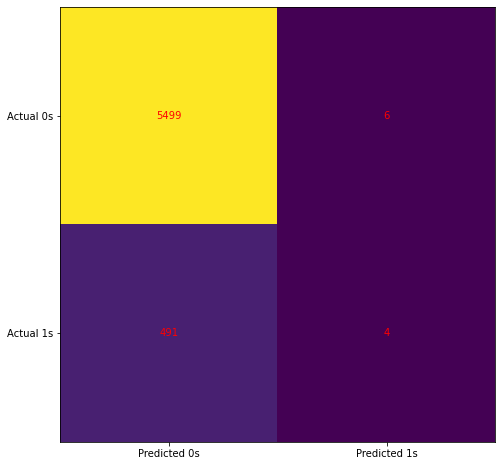

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, model.predict(test_features))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [21]:
from sklearn.metrics import f1_score
f1 = f1_score(test_labels, model.predict(test_features))
print('F1 score: %f' % f1)

F1 score: 0.015842


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=binary as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
